<a href="https://colab.research.google.com/github/mymess/Jupyter-Notebooks/blob/master/Multivariate_regression_California_housing_prices_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#The data

##Collecting the data
Let's create a class that downloads CSV files into a specific folder in our local machine. It might be useful in case the data is updated regularly and we want to repeat this task. Next, let's use this class and take a quick look at the data.


Saving figure attribute_histogram_plots


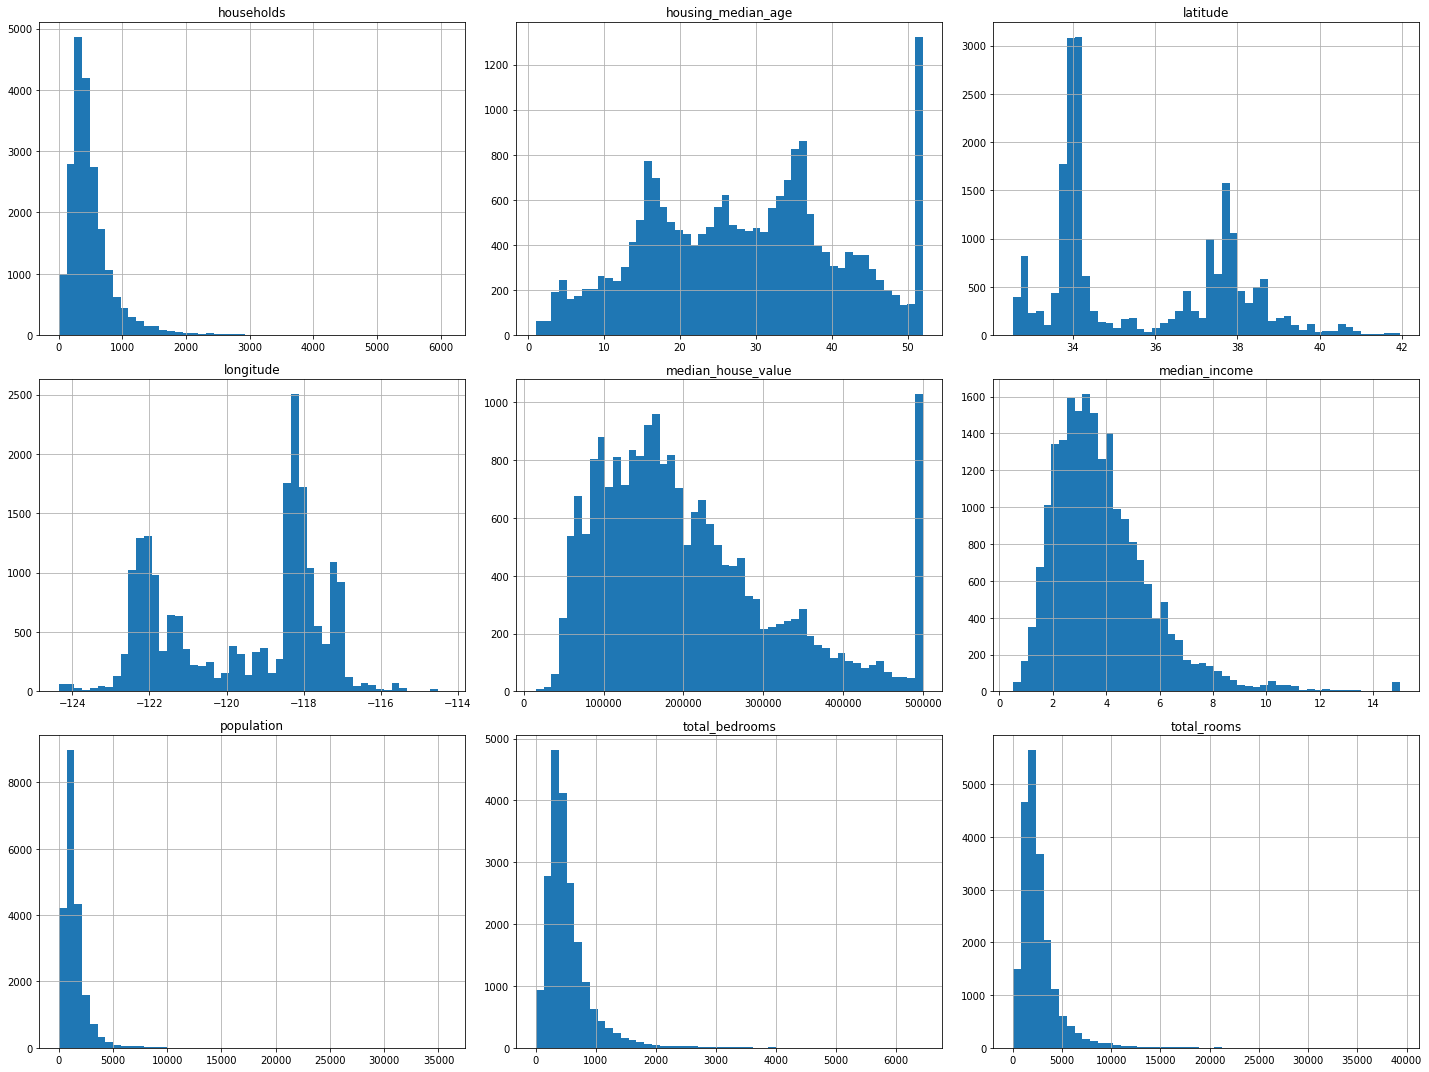

In [0]:
%matplotlib inline
import os
import tarfile
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import warnings; warnings.simplefilter('ignore')

from six.moves import urllib

PROJECT_ROOT_DIR = "."
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
LOCAL_PATH    = os.path.join("datasets/housing")
DATA_URL      = DOWNLOAD_ROOT + "datasets/housing/housing.csv"
FILENAME      = "housing.csv"
IMAGES_PATH   =  os.path.join(PROJECT_ROOT_DIR, "img")


def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    if not os.path.isdir( IMAGES_PATH ):
        os.makedirs( IMAGES_PATH )
        
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


class DataFetcher:

    def __init__(self, url, local_path, filename):
        self.url = url
        self.local_path = local_path
        self.filename = filename
        #self.fetch_data()



    def fetch_tar_file(self):
        if not os.path.isdir(self.local_path ):
            os.makedirs( self.local_path )

        tgz_path = os.path.join(self.local_path, self.filename)
        print( "\nDownloading '" + self.url + "' to " + tgz_path);
        urllib.request.urlretrieve(self.url, tgz_path)
        tgz_file = tarfile.open(tgz_path)
        tgz_file.extractall(path=self.local_path)
        tgz_file.close()
        
    def fetch_csv_file(self):
        if not os.path.isdir(self.local_path ):
            os.makedirs( self.local_path )
        csv_path = os.path.join(self.local_path, self.filename)
        print( "\nDownloading '" + self.url + "' to " + csv_path);
        urllib.request.urlretrieve(self.url, csv_path)
        

    def load_data(self):
        csv_path = os.path.join(self.local_path, self.filename)
        return pd.read_csv(csv_path, error_bad_lines=False)

df = DataFetcher( DATA_URL, LOCAL_PATH, FILENAME);
df.fetch_csv_file()

housing_df = df.load_data()
#print( housing_dataframe.head() )

housing_df = df.load_data()

housing_df.dropna()

housing_df.hist(bins=50, figsize=(20, 15))

save_fig("attribute_histogram_plots")


plt.show()

In [0]:
housing_df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


##Split into test set and train set 
We may want to directly split the dataset into train set and test set. The problem is that if we do it randomly there will probably be sampling bias. Sampling bias occurs when we split the data into train set and test set randomly and the attribute which correlates best with the target attribute is not equally distribituted between both sets.



In [0]:
# to make this notebook's output identical at every run
from sklearn.model_selection import train_test_split
np.random.seed(42)

train_set, test_set = train_test_split(housing_df, test_size=0.2, random_state=42)




## Stratified sampling on median_income

Let's create a class that splits the dataset into training set and data set and avoids sampling bias. 

In [0]:
import hashlib
from zlib import crc32
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
import pandas as pd

RANDOM_SEED = 42
np.random.seed( RANDOM_SEED )

class DatasetSplitter:

	def __init__(self, data, test_ratio, id_column):
		self.data       = data
		self.test_ratio = test_ratio
		self.id_column  = id_column
		self.data_split_by_attribute = False;


	def split_train_test_by_id(self):
	    ids = self.data[self.id_column]
	    in_test_set = ids.apply(lambda id_: self.test_set_check(id_))
	    return self.data.loc[~in_test_set], self.data.loc[ in_test_set ]

	def test_set_check(self, identifier,  hash=hashlib.md5):
		b_array = bytearray(hash(np.int64(identifier)).digest())
		return b_array[-1] < (256 * self.test_ratio)

	def split_train_test(self):
		return train_test_split(self.data, test_size=self.test_ratio, random_state=RANDOM_SEED);

	#stratified sampling by attribute
	def split_by_attribute(self, attribute):
		split = StratifiedShuffleSplit(1, self.test_ratio, random_state=RANDOM_SEED)
		self.strat_attribute = attribute
		

		for train_index, test_index in split.split(self.data, self.data[attribute]):
			self.strat_train_set = self.data.loc[train_index]
			self.strat_test_set  = self.data.loc[test_index]
		
		self.data_split_by_attribute = True;

	#returns the train_set and test_set after stratified sampling
	def get_stratified_datasets(self):
		return self.strat_train_set, self.strat_test_set


	def proportions(self, dataset):
		if not self.data_split_by_attribute:
			print("The datasets were not sampled by strata.")
			return;
		return dataset[ self.strat_attribute ].value_counts() / len(dataset)

	#compares both random and stratified split 
	def compare_random_vs_strat_split(self):
		if not self.data_split_by_attribute:
			print("The datasets were not sampled by strata.")
			return

		train_set, test_set = self.split_train_test();

		compare_props = pd.DataFrame({
    		"Overall": self.proportions(self.data),
    		"Stratified": self.proportions(self.strat_test_set),
    		"Random": self.proportions( test_set ),
		}).sort_index()

		compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
		compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

		print ( "\n\n----Random vs Stratified sampling based on attribute '{1}'----\n", self.strat_attribute );

		print ( "\n\n----Random vs Stratified sampling on TEST SET----\n" );
		print ( compare_props );

		compare_props = pd.DataFrame({
	    	"Overall": self.proportions(self.data),
	    	"Stratified": self.proportions(self.strat_train_set),
	    	"Random": self.proportions( train_set ),
		}).sort_index()

		compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
		compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

		print ( "\n\n----Random vs Stratified sampling on TRAIN SET----\n" );
		print ( compare_props );






And now let's use this class. Note that the best correlating attribute (median_income) is used to stratify first the data into income categories outside of the class. The method split_by_attribute receives the attribute 'income_cat', which indicates the parameter which is to be distributed equally between train set and test set and thus avoiding sampling bias. Next we compare the goodness of our stratified sampling (note that the strat %error is close to zero, whereas the random %error is larger in absolute terms):

In [0]:
housing_with_id = housing_df.reset_index()   # adds an `index` column

housing_with_id["id"] = housing_with_id["index"]#housing_df["longitude"] * 1000 + housing_df["latitude"]

#stratify in 5 income categories to do stratified sampling
#put together the tail of the highest income into category 5
housing_with_id["income_cat"] = pd.cut(housing_with_id[ 'median_income' ],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])



splitter = DatasetSplitter(housing_with_id, 0.2, "id")
splitter.split_by_attribute( "income_cat" )
splitter.compare_random_vs_strat_split();

train_set, test_set = splitter.get_stratified_datasets()

#let's clean the data
for set_ in (train_set, test_set):
	set_.drop("income_cat", axis=1, inplace=True)
	set_.drop("index", axis=1, inplace=True)
	set_.drop("id", axis=1, inplace=True)
  
housing_ts = train_set.copy();



----Random vs Stratified sampling based on attribute '{1}'----
 income_cat


----Random vs Stratified sampling on TEST SET----

    Overall  Stratified    Random  Rand. %error  Strat. %error
1  0.039826    0.039729  0.040213      0.973236      -0.243309
2  0.318847    0.318798  0.324370      1.732260      -0.015195
3  0.350581    0.350533  0.358527      2.266446      -0.013820
4  0.176308    0.176357  0.167393     -5.056334       0.027480
5  0.114438    0.114583  0.109496     -4.318374       0.127011


----Random vs Stratified sampling on TRAIN SET----

    Overall  Stratified    Random  Rand. %error  Strat. %error
1  0.039826    0.039850  0.039729     -0.243309       0.060827
2  0.318847    0.318859  0.317466     -0.433065       0.003799
3  0.350581    0.350594  0.348595     -0.566611       0.003455
4  0.176308    0.176296  0.178537      1.264084      -0.006870
5  0.114438    0.114402  0.115673      1.079594      -0.031753


##Visualizing geographical data
Since we have geographical coordinates of each district in our dataset, it is posible to visualize geolocalized data.

Saving figure scatter_plot_bad
Saving figure scatter_plot_alpha
Saving figure scatter_plot_colored


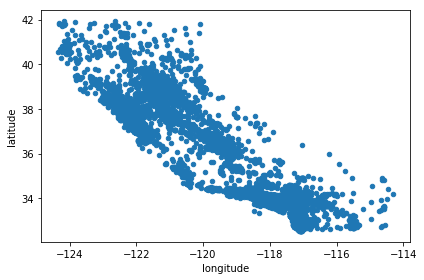

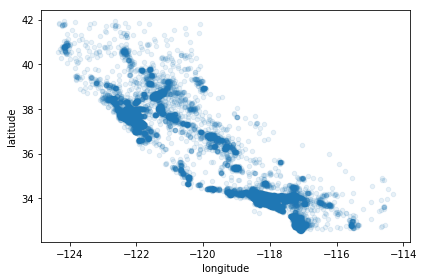

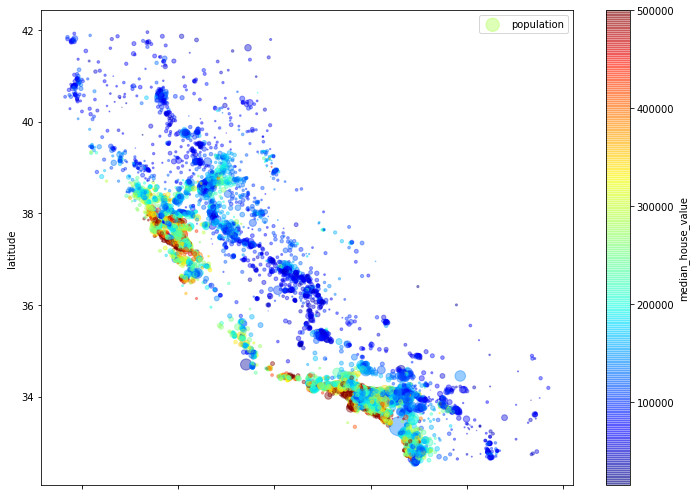

In [0]:
housing_ts.plot(kind="scatter", x="longitude", y="latitude")
save_fig("scatter_plot_bad")

housing_ts.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)
save_fig("scatter_plot_alpha")

#colored na
housing_ts.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
	s=housing_ts["population"] / 100, label="population", figsize=(10 ,7), c="median_house_value",
	cmap=plt.get_cmap("jet"), colorbar=True,)
save_fig("scatter_plot_colored")

plt.legend();


Cool, uh?

##Correlations between attributes
Let's create a class that helps us looking for correlations.

In [0]:
import pandas as pd
from pandas.plotting import scatter_matrix

class CorrelationPlotter:

	def __init__(self, data, attributes):

		self.data 		= data
		self.attributes = attributes

	def correlate_by_attribute(self, corr_attr):
		corr_matrix = self.data.corr()
		corr_matrix[ corr_attr ].sort_values(ascending=False)
		print (corr_matrix )

	def plot_corr_matrix(self):
		scatter_matrix(self.data[self.attributes], figsize=(12, 8))


	def plot_attribute_pair_corr(self, x_attr, y_attr, alpha=.1):
		self.data.plot( kind = "scatter", x=x_attr, y=y_attr, alpha=alpha)

Now let's use the class:

                    longitude  latitude  housing_median_age  total_rooms  \
longitude            1.000000 -0.924478           -0.105848     0.048871   
latitude            -0.924478  1.000000            0.005766    -0.039184   
housing_median_age  -0.105848  0.005766            1.000000    -0.364509   
total_rooms          0.048871 -0.039184           -0.364509     1.000000   
total_bedrooms       0.076598 -0.072419           -0.325047     0.929379   
population           0.108030 -0.115222           -0.298710     0.855109   
households           0.063070 -0.077647           -0.306428     0.918392   
median_income       -0.019583 -0.075205           -0.111360     0.200087   
median_house_value  -0.047432 -0.142724            0.114110     0.135097   

                    total_bedrooms  population  households  median_income  \
longitude                 0.076598    0.108030    0.063070      -0.019583   
latitude                 -0.072419   -0.115222   -0.077647      -0.075205   
housing_

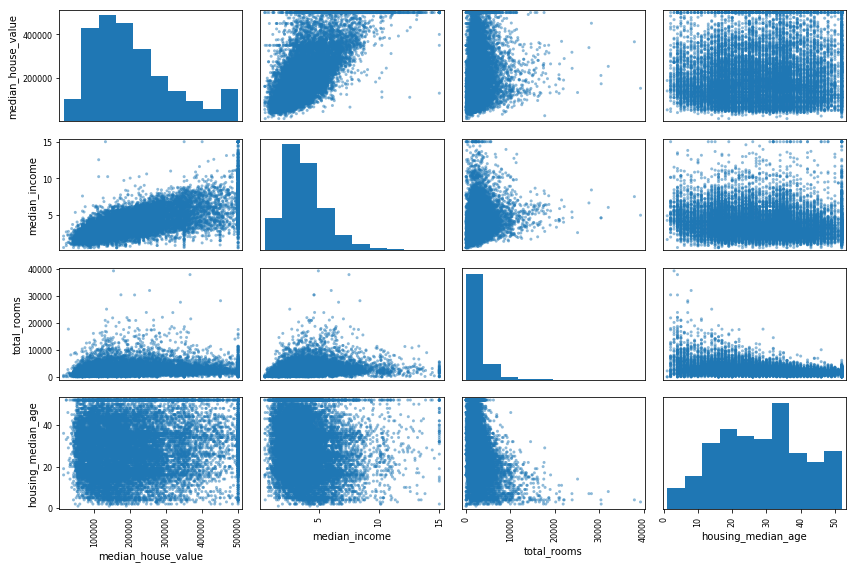

In [0]:
attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]

correlation = CorrelationPlotter(housing_ts, attributes)

correlation.correlate_by_attribute("median_income")
correlation.plot_corr_matrix()

save_fig("scatter_matrix_plot")



As we can see, the strongest correlation happens between the median_income and the median_house_value. Let's look closer at the correlation between those attributes:


Saving figure median_income_vs_median_house_value


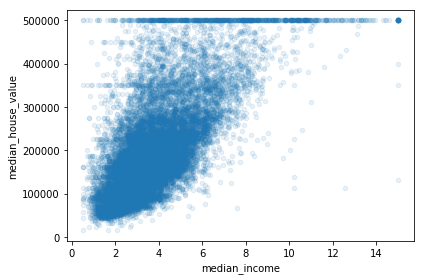

In [0]:
correlation.plot_attribute_pair_corr("median_income", "median_house_value")
save_fig("median_income_vs_median_house_value")

Let's create other attributes that make more sense:

                          longitude  latitude  housing_median_age  \
longitude                  1.000000 -0.924478           -0.105848   
latitude                  -0.924478  1.000000            0.005766   
housing_median_age        -0.105848  0.005766            1.000000   
total_rooms                0.048871 -0.039184           -0.364509   
total_bedrooms             0.076598 -0.072419           -0.325047   
population                 0.108030 -0.115222           -0.298710   
households                 0.063070 -0.077647           -0.306428   
median_income             -0.019583 -0.075205           -0.111360   
median_house_value        -0.047432 -0.142724            0.114110   
rooms_per_household       -0.028345  0.107621           -0.147186   
bedrooms_per_room          0.095603 -0.116884            0.136788   
population_per_household  -0.000410  0.005420            0.015031   

                          total_rooms  total_bedrooms  population  households  \
longitude            

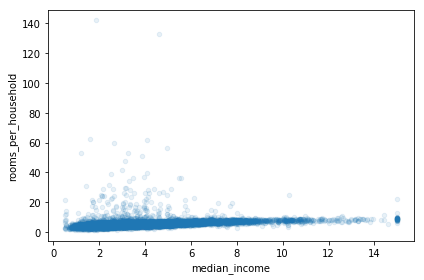

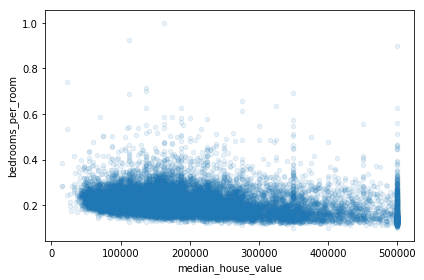

In [0]:
housing_ts["rooms_per_household"] = housing_ts["total_rooms"]/housing_ts["households"]
housing_ts["bedrooms_per_room"] = housing_ts["total_bedrooms"]/housing_ts["total_rooms"]
housing_ts["population_per_household"]=housing_ts["population"]/housing_ts["households"]


attributes = ["median_house_value", "median_income", "rooms_per_household",
              "housing_median_age"]

correlation = CorrelationPlotter(housing_ts, attributes)
correlation.correlate_by_attribute("median_house_value")

correlation.plot_attribute_pair_corr("median_income", "rooms_per_household")
save_fig("median_income_vs_rooms_per_household")

correlation.plot_attribute_pair_corr("median_house_value", "bedrooms_per_room")
save_fig("median_house_value_vs_bedrooms_per_room")

As we can see, the bedrooms_per_room attribute is much more correlated with the median house value than the total number of rooms or bedrroms in a district. It makes sense that houses with a lower bedroom-room ratio tend to be more expensive (there are more leisure areas).

#The algorithms
##Preparing the data for ML algorithms
###1. Separating the predictor attributes and the label
First, we want to separate the predictor attributes and the target attribute (the label) since we don't necessarily apply the same transformations to both types of attributes:


In [0]:
housing = housing_ts.drop("median_house_value", axis=1)
housing_labels= housing_ts["median_house_value"].copy()

###2. Getting rid of null values
We could create a class that cleans the data set of null values following different strategies as follows. But, as we will see, this is unnecessary, as ScikitLearn pipelines has already implemented an Imputer class, which we can pass to a pipeline (or we could create a custom one if needed):

In [0]:
import pandas as pd
from pandas.api.types import is_numeric_dtype

#cleans null fields following different strategies
class DataCleaner:

	def __init__(self, data):
		self.data = data


	def get_data(self):
		return self.data

	#drops the whole row (the whole record) if the given attribute is null
	def drop_rows_where_null_value(self, attribute ):
		self.data = self.data.dropna(subset=[ attribute ])

	#drops the whole attribute (the whole column) if any null
	def drop_attribute_if_any_null_value(self, attribute ):
		self.data = self.data.drop(subset=attribute, axis=1)

	#replaces nulls by median of the attribute
	def replace_nulls_by_median(self, attribute):
		median = self.data[attribute].median()
		self.data[ attribute ].fillna(median, inplace=True)

	#replaces nulls by mean of the attribute
	def replace_nulls_by_mean(self, attribute):
		mean = self.data[attribute].mean()
		self.data[ attribute ].fillna(mean, inplace=True)

	#replaces nulls by zero 
	def replace_nulls_by_zero(self, attribute):
		self.data[ attribute ].fillna(0, inplace=True)

	#replaces nulls by a given value 
	def replace_nulls_by_value(self, attribute, replacing_value ):
		self.data[ attribute ].fillna(replacing_value, inplace=True)


	#looks for nulls in all attributes and replaces them by a value
	def replace_all_null_attributes_by_value(self, value="median", replacing_value=0):
		#iterate over attributes
		for attribute in self.data:			
			#check if attribute is float or null value
			if is_numeric_dtype( self.data[attribute] ):
				#if is numeric, call corresponding strategy
				if value=="mean":
					self.replace_nulls_by_mean(attribute)
				elif value=="zero":
					self.replace_nulls_by_zero(attribute)
				elif value=="median":
					self.replace_nulls_by_median(attribute)
				elif value=="value":
					self.replace_nulls_by_value(attribute, replacing_value)
				else:
					print ("Wrong replacing strategy")

	def is_float_or_null(self, attribute):
		return self.data[attribute].dtype in [pd.np.dtype('float64'), 
		pd.np.dtype('float32'), 
		pd.np.dtype('NaN')] 



**THIS IS IMPORTANT:** we need to remove the label attribute from the training set and work with this dataframe:

In [0]:
categorical_attr = ["ocean_proximity"]

housing = housing_ts.drop("median_house_value", axis=1, inplace=False)

housing_cat = housing[ categorical_attr ]
housing_num = housing.drop( housing_cat.columns, axis=1 )


###3. Handling numerical and categorical attributes using Pipelines


We have to apply different transformations to both numerical and categorical attributes. Let's do this by using the transformation pipelines provided by ScikitLearn. But first, let's separate the training set into two dataframes, one for numerical attributes and the other one for categorical attributes.

In [0]:
categorical_attr = ["ocean_proximity"]
housing_cat = housing[ categorical_attr ]
housing_num = housing.drop( housing_cat.columns, axis=1 )

Now, let's focus on the transformations that need to be done on the numerical attributes dataset. First, the class to clean the data of null values implemented earlier, is already given by SimpleImuter class. Coming next in the pipeline is the calculation and extension of the dataset with some composed attributes.This is performed by CombineAttributesClass. And last in the pipeline is the StandardScaler(), which scales the data based on the Variation Coefficient.

In [0]:
############
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import sklearn


# get the right column indices: safer than hard-coding indices 3, 4, 5, 6
rooms_ix, bedrooms_ix, population_ix, household_ix = [
    list(housing.columns).index(col)
    for col in ("total_rooms", "total_bedrooms", "population", "households")]

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kwargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

##########


from sklearn.impute import SimpleImputer # Scikit-Learn 0.20+



num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder() ),
        ('std_scaler', StandardScaler()),
    ])

And now there is a single transformation that needs to be done on the categorical attributes (in our example, there is only one categorical attribute, the ocean_proximity attribute), which is OneHotEncoder. This is necessary so that categories are encoded into onehot vectors (bitvectors with only one bit set to 1, and the rest to zeros) and not integers, which would mislead the ML algorithms into finding hidden patterns there.

In [0]:
cat_encoder = OneHotEncoder(sparse=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)


Let's run the pipeline and get our processed data:

In [0]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]



full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])


housing_prepared = full_pipeline.fit_transform(housing)

print(housing_prepared)

[[-1.15604281  0.77194962  0.74333089 ...  0.          0.
   0.        ]
 [-1.17602483  0.6596948  -1.1653172  ...  0.          0.
   0.        ]
 [ 1.18684903 -1.34218285  0.18664186 ...  0.          0.
   1.        ]
 ...
 [ 1.58648943 -0.72478134 -1.56295222 ...  0.          0.
   0.        ]
 [ 0.78221312 -0.85106801  0.18664186 ...  0.          0.
   0.        ]
 [-1.43579109  0.99645926  1.85670895 ...  0.          1.
   0.        ]]


##Applying the algorithms



###1. First try: Linear Regression model

Let's create a linear regression model to our housing_prepared array and compare it to our target values (the label attribute).


In [0]:
housing_prepared = full_pipeline.fit_transform(housing)

from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

some_data   = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions: ", lin_reg.predict(some_data_prepared))
print("Labels: ", list(some_labels))

Predictions:  [209420.50610494 315409.32621299 210124.77314125  55983.75406116
 183462.63421725]
Labels:  [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


As we can see, there is a big error between predicted and label values. Let's see how big it is with the RMSE:

In [0]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
print("RMSE = {:.2f}$".format(lin_rmse))

RMSE = 68147.96$


An RMSE of about 70.000$ for a house price prediction is quite disappointing. One could argue that the data has many outliers, and the RMSE is very sensitive to them. So let's try the MAE:

In [0]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(housing_labels, housing_predictions)
print("MAE = {:.2f}$".format(lin_mae))

MAE = 49072.48$


The MAE is about 50.000$, which is still unacceptable for a price prediction. This means that a linear regression model is underfitting our data, i.e. it is NOT POWERFUL ENOUGH. Let's try with another model.

###2. Second try: Decision Tree model



In [0]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor(random_state=42)

tree_reg.fit(housing_prepared, housing_labels)

housing_predictions = tree_reg.predict(housing_prepared)

tree_mse = mean_squared_error(housing_labels, housing_predictions)

tree_rmse = np.sqrt(tree_mse)

print("RMSE = {:.2f}$".format(tree_rmse))



RMSE = 0.00$


Now we have the opposite extreme! A Decision tree model is most likely overfitting our data. But how can we prove that? Let's make cross-validation of our a Decission Tree model by implementing a class that handles both the cross-validation of a Decision Tree Regression model and the cross validation of a Linear Regression model:


In [0]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

RANDOM_STATE = 42

class CrossValidator:


	def __init__(self, data, labels ):
		self.tree_reg = DecisionTreeRegressor(random_state=RANDOM_STATE)
		self.tree_reg.fit(data, labels)
		self.tree_predictions = self.tree_reg.predict(data)
		self.data   = data
		self.labels = labels

		tree_mse  = mean_squared_error(self.labels, self.tree_predictions)
		tree_rmse = np.sqrt(tree_mse)

		print("Tree RMSE = ", tree_rmse)


		self.lin_reg = LinearRegression()
		self.lin_reg.fit( data, labels )
		self.lin_predictions = self.lin_reg.predict(data)
		lin_mse = mean_squared_error(labels, self.lin_predictions)
		lin_rmse = np.sqrt(lin_mse)
		print("Linear RMSE = ", lin_rmse)


	def display_scores(self, scores):
		print("Scores:", scores)
		print("Mean:", scores.mean())
		print("Standard deviation:", scores.std())

	

	def cross_validate(self, folds=10):
		print("\nDECISION TREE RMSE SCORES ----")
		scores = cross_val_score(self.tree_reg, self.data, self.labels,
                         scoring="neg_mean_squared_error", cv=folds)
		tree_rmse_scores = np.sqrt(-scores)
		self.display_scores(tree_rmse_scores)

		print("\nLINEAR RMSE SCORES ----")
		lin_scores = cross_val_score(self.lin_reg, self.data, self.labels,
                             scoring="neg_mean_squared_error", cv=folds)
		lin_rmse_scores = np.sqrt(-lin_scores)
		self.display_scores(lin_rmse_scores)




Now let's run the class:

In [0]:
cv = CrossValidator(housing_prepared, housing_labels)
cv.cross_validate()

Yeap. The Decision Tree model is overfitting our model so badly that it performs even worse than the Linear Regression model.  So let's try another model

###3. Third try: RandomForest model

In [0]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=10, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
print("RMSE = {:.2f}$".format(forest_rmse))

RMSE = 22006.00$


Looks better! But let's first add this last model to our CrossValidator class, so we can compare all of them:

###4. The complete CrossValidator class


In [0]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

from sklearn.ensemble import RandomForestRegressor



RANDOM_STATE = 42

class CrossValidator:


	def __init__(self, data, labels ):
		self.tree_reg = DecisionTreeRegressor(random_state=RANDOM_STATE)
		self.tree_reg.fit(data, labels)
		self.tree_predictions = self.tree_reg.predict(data)
		self.data   = data
		self.labels = labels

		tree_mse  = mean_squared_error(self.labels, self.tree_predictions)
		tree_rmse = np.sqrt(tree_mse)

		print("Tree RMSE = ", tree_rmse)


		self.lin_reg = LinearRegression()
		self.lin_reg.fit( data, labels )
		self.lin_predictions = self.lin_reg.predict(data)
		lin_mse = mean_squared_error(labels, self.lin_predictions)
		lin_rmse = np.sqrt(lin_mse)
		print("Linear RMSE = ", lin_rmse)


		self.forest_reg = RandomForestRegressor(n_estimators=10, 
			random_state=RANDOM_STATE)
		self.forest_reg.fit(self.data, self.labels)
		self.forest_predictions = self.forest_reg.predict(data)
		forest_mse = mean_squared_error(labels, self.forest_predictions)
		forest_rmse = np.sqrt(forest_mse)
		print("Random Forest RMSE =", forest_rmse)


	def display_scores(self, scores):
		print("Scores:", scores)
		print("Mean:", scores.mean())
		print("Standard deviation:", scores.std())

	

	def cross_validate(self, folds=10):
		print("\nDECISION TREE RMSE SCORES ----")
		scores = cross_val_score(self.tree_reg, self.data, self.labels,
                         scoring="neg_mean_squared_error", cv=folds)
		tree_rmse_scores = np.sqrt(-scores)
		self.display_scores(tree_rmse_scores)

		print("\nLINEAR RMSE SCORES ----")
		lin_scores = cross_val_score(self.lin_reg, self.data, self.labels,
                             scoring="neg_mean_squared_error", cv=folds)
		lin_rmse_scores = np.sqrt(-lin_scores)
		self.display_scores(lin_rmse_scores)


		print("\nRANDOM FOREST RMSE SCORES ----")
		forest_scores = cross_val_score(self.forest_reg, self.data, self.labels,
                                scoring="neg_mean_squared_error", cv=folds)
		forest_rmse_scores = np.sqrt(-forest_scores)
		self.display_scores(forest_rmse_scores)


Let's run the class:

In [0]:
cv = CrossValidator(housing_prepared, housing_labels)
cv.cross_validate()

Tree RMSE =  0.0
Linear RMSE =  68147.95744947501
Random Forest RMSE = 22006.00451167395

DECISION TREE RMSE SCORES ----
Scores: [70277.4805955  67294.81596029 69265.63901873 70089.21394282
 70261.02658556 73267.68290323 70751.17733326 70514.56892509
 74967.72616267 71203.3455473 ]
Mean: 70789.26769744355
Standard deviation: 1985.298594627021

LINEAR RMSE SCORES ----
Scores: [66063.66020188 66793.78724541 67653.63917569 74702.95282053
 68054.75502851 70902.35184092 64171.47270772 68077.27757538
 71042.4918974  67281.01437174]
Mean: 68474.34028651725
Standard deviation: 2843.7273240642116

RANDOM FOREST RMSE SCORES ----
Scores: [51937.94588396 48821.51858959 53352.19732045 54895.39217132
 51342.19116741 56583.42786688 52143.90385489 49790.1318331
 55009.77704994 53243.61550334]
Mean: 52712.01012408743
Standard deviation: 2284.706339049741


Thanks to our CrossValidator class we can see at one glance that the Random Forrest model beats the other two. However, note that 
the Training Set score < Validation Set score, meaning that it's still overfitting the Training set.

##Fine-tuning the model


###1. Grid Search

In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor


param_grid = [
	{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
	{'bootstrap':[False], 'n_estimators':[3, 10], 'max_features': [2,3,4]}
]


forest_reg = RandomForestRegressor()

grid_search = GridSearchCV( forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error')

grid_search.fit(housing_prepared, housing_labels)

print("\nBest params = " , grid_search.best_params_)
print("\nBest Estimator = " , grid_search.best_estimator_)

cvres = grid_search.cv_results_
print("\nScores: ")
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
	print (np.sqrt(-mean_score), params)


Best params =  {'max_features': 8, 'n_estimators': 30}

Best Estimator =  RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=None, oob_score=False,
           random_state=None, verbose=0, warm_start=False)

Scores: 
65790.76701700262 {'max_features': 2, 'n_estimators': 3}
57012.45014682832 {'max_features': 2, 'n_estimators': 10}
54458.541065922356 {'max_features': 2, 'n_estimators': 30}
61699.66217144968 {'max_features': 4, 'n_estimators': 3}
54445.37761565152 {'max_features': 4, 'n_estimators': 10}
51704.03828759625 {'max_features': 4, 'n_estimators': 30}
60571.43360840084 {'max_features': 6, 'n_estimators': 3}
53494.290039000465 {'max_features': 6, 'n_estimators': 10}
51099.725467312186 {'max_features': 6, 'n_estimators': 30}
59928.737662

The minimum score is 50996.51859423116 {'max_features': 8, 'n_estimators': 30}, which is a bit lower than the one obtained before, 52712.01012408743. We have fine tuned our system!

###3. Randomized search

Let's use the Randomized search approach to see if it performs better than the Grid search approach.

In [0]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

print("\nBest params = " , rnd_search.best_params_)
print("\nBest Estimator = " , rnd_search.best_estimator_)

print("\nScores: ")
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)


Best params =  {'max_features': 7, 'n_estimators': 180}

Best Estimator =  RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=180, n_jobs=None, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

Scores: 
50119.789491596566 {'max_features': 7, 'n_estimators': 180}
52607.8112326982 {'max_features': 5, 'n_estimators': 15}
52081.38154084223 {'max_features': 3, 'n_estimators': 72}
52101.318133478264 {'max_features': 5, 'n_estimators': 21}
50147.60565161175 {'max_features': 7, 'n_estimators': 122}
52038.96967104615 {'max_features': 3, 'n_estimators': 75}
52031.44020670874 {'max_features': 3, 'n_estimators': 88}
50712.72732970037 {'max_features': 5, 'n_estimators': 100}
51776.87042494469 {'max_features': 3, 'n_estimators': 150}
65805.9

Yeap, the Randomized search approach has found out that the best result comes with {'max_features': 5, 'n_estimators': 100}, the MSE = 50712.727, which is a bit lower than  the MSE obtained with Grid search, whic was 50996.51. Not a great improvement, but it's ok.

## Analyzing the best model
We can display the importance the attributes have in our model next to their names as follows:

In [0]:
feature_importances = rnd_search.best_estimator_.feature_importances_


extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
#cat_encoder = cat_pipeline.named_steps["cat_encoder"] # old solution
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs

sorted(zip(feature_importances, attributes), reverse=True)


[(0.31439673238852034, 'median_income'),
 (0.1582382352206372, 'INLAND'),
 (0.06509194608312886, 'population_per_household'),
 (0.06367580062789975, 'pop_per_hhold'),
 (0.06304790606194642, 'bedrooms_per_room'),
 (0.06218649074689169, 'longitude'),
 (0.05690262816537032, 'latitude'),
 (0.041489334102062986, 'bedrooms_per_room'),
 (0.04026056483972639, 'housing_median_age'),
 (0.03484232342843427, 'rooms_per_hhold'),
 (0.03215253171886169, 'rooms_per_household'),
 (0.014199512014448004, 'total_rooms'),
 (0.013656209056674065, 'population'),
 (0.01365589805315417, 'total_bedrooms'),
 (0.013386499323552268, 'households'),
 (0.007227420626620638, '<1H OCEAN'),
 (0.003191750962075465, 'NEAR OCEAN'),
 (0.0023218949873601872, 'NEAR BAY'),
 (7.632159263521457e-05, 'ISLAND')]

#Testing the model
We can finally test our model with the test set:

In [0]:
final_model = rnd_search.best_estimator_

X_test = test_set.drop("median_house_value", axis=1)
y_test = test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

print("TEST SET RMSE = ", final_rmse)

TEST SET RMSE =  54375.7889412175


As we can see, after fine tuning the system, the performance drops, as the system ends up fine-tuned to perform well on the validation data, but not on the test set. Paradox!